In [189]:
import numpy as np
import pandas as pd


# download dataframe
data = pd.read_csv('Bitcoin_2014-2022.csv',index_col=0)
data.index = pd.to_datetime(data.index)
log_returns = pd.DataFrame(np.diff(np.log(data['Close'])),index=data.index[1:],columns=['Log_Returns'])


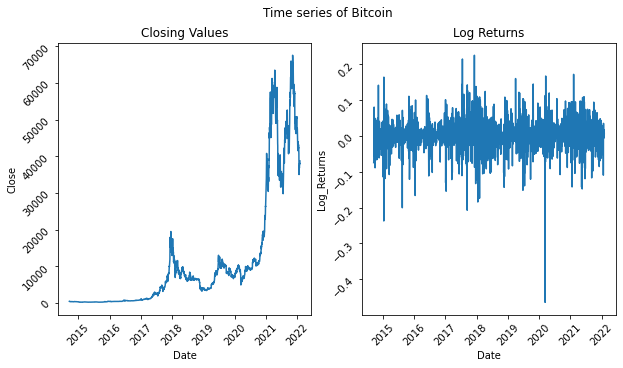

In [190]:
import matplotlib.pyplot as plt
import seaborn as sns


fig, axs = plt.subplots(1,2, figsize=(10, 5), squeeze=True)
sns.lineplot(x=data.index, y='Close', data=data, ax=axs[0])
sns.lineplot(x=log_returns.index, y='Log_Returns', data=log_returns,ax=axs[1])

axs[0].title.set_text('Closing Values')
axs[0].tick_params(labelrotation=45)

axs[1].title.set_text('Log Returns')
axs[1].tick_params(labelrotation=45)

fig.suptitle('Time series of Bitcoin')
plt.show()

Text(0.5, 0.98, 'AutoCorrelation Plots')

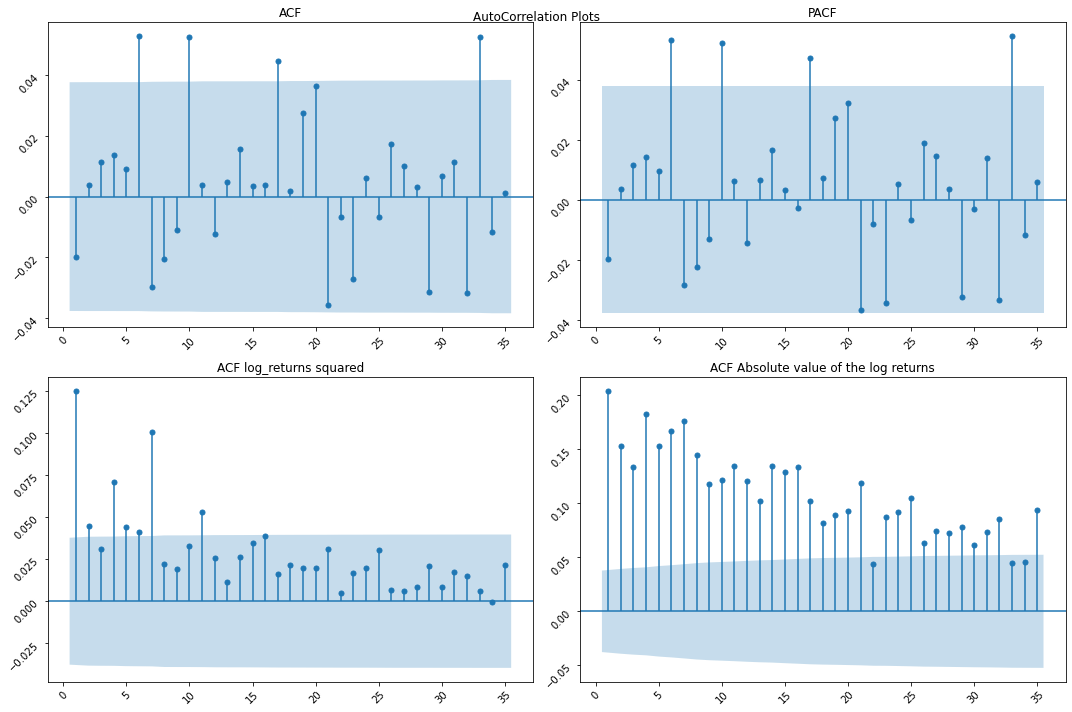

In [191]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axs = plt.subplots(2,2, figsize=(15, 10), squeeze=True)
plot_acf(log_returns, ax=axs[0,0], zero=False)
plot_pacf(log_returns, ax=axs[0,1], zero=False)
plot_acf(log_returns**2, ax=axs[1,0], zero=False)
plot_acf(abs(log_returns), ax=axs[1,1], zero=False)


axs[0,0].title.set_text('ACF')
axs[0,0].tick_params(labelrotation=45)

axs[0,1].title.set_text('PACF')
axs[0,1].tick_params(labelrotation=45)

axs[1,0].title.set_text('ACF log_returns squared')
axs[1,0].tick_params(labelrotation=45)

axs[1,1].title.set_text('ACF Absolute value of the log returns')
axs[1,1].tick_params(labelrotation=45)
fig.tight_layout()
fig.suptitle('AutoCorrelation Plots')

In [192]:
import pmdarima as arima
from arch import arch_model

arima_model_fitted = arima.auto_arima(log_returns)

arima_residuals = arima_model_fitted.arima_res_.resid

model = arch_model(arima_residuals, vol='GARCH', p=1, q=1, rescale=True)
fitted_model = model.fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 30880.317092146983
Iteration:      2,   Func. Count:     16,   Neg. LLF: 13736.457324680989
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2312.8696738780855
Iteration:      4,   Func. Count:     33,   Neg. LLF: 1715.071991240392
Iteration:      5,   Func. Count:     40,   Neg. LLF: 2395.486742762866
Iteration:      6,   Func. Count:     47,   Neg. LLF: 1074.2407241908898
Iteration:      7,   Func. Count:     53,   Neg. LLF: 1074.7685281612653
Iteration:      8,   Func. Count:     59,   Neg. LLF: 1073.6158810237753
Iteration:      9,   Func. Count:     64,   Neg. LLF: 1073.6141152118673
Iteration:     10,   Func. Count:     69,   Neg. LLF: 1073.6140876424793
Iteration:     11,   Func. Count:     73,   Neg. LLF: 1073.614087642061
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1073.6140876424793
            Iterations: 11
            Function evaluations: 73
            Gradient evalua

In [193]:
print(fitted_model.scale)

10.0


In [194]:
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -1073.61
Distribution:                  Normal   AIC:                           2155.23
Method:            Maximum Likelihood   BIC:                           2178.82
                                        No. Observations:                 2694
Date:                Wed, Feb 23 2022   Df Residuals:                     2693
Time:                        22:00:27   Df Model:                            1
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         2.5810e-03  6.656e-03      0.388      0.698 [-1.047e-02,1.563e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      6.9523e-03  2.499e-03      2.782  5.398e-03 [2.055e-03,1.185e-02]
alpha[1]       0.1284  3.614e-02      3.553  3.803e-04   [5.758e-02,  0.199]
beta[1]        0.8394  2.844e-02     29.517 1.725e-191     [  0.784,  0.895]
============================================================================

Covariance estimator: robust
"""

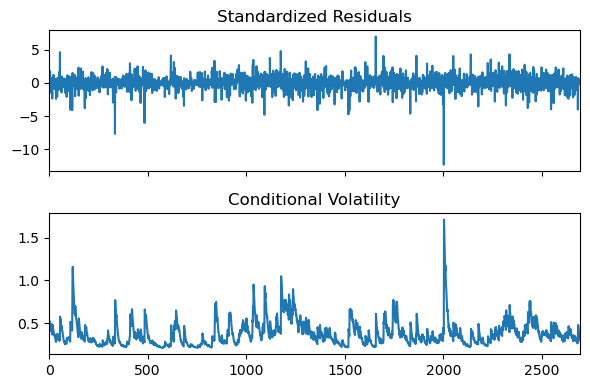

In [195]:
results = fitted_model.plot()
results.tight_layout()
results.set_dpi(100)

In [196]:
forecast = fitted_model.forecast(reindex=False)
print(np.sqrt(forecast.residual_variance.values[0]))


[0.02873292]
[0.02873292]
10.0
100.0


In [19]:
import dill

with open('GARCH_10_sims_3_days_rebuild_10.dill','rb') as f:
    TS = dill.load(f)

TS.Simulation_Statistics()

FileNotFoundError: [Errno 2] No such file or directory: 'GARCH_10_sims_3_days_rebuild_10.dill'